In [36]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

PROJECT_PATH = os.getenv('PROJECT_DIR')
sys.path.append(PROJECT_PATH)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [37]:
# custom modules
from src.data_ingestion.iex_data import IexDataFetcher
from src.data_ingestion.weather_data import WeatherDataFetcher
from src.feature_engineering.build_features import FeatureEngineering
from src.model_building.train_model import ModelTraining
from src.model_building.eval_model import ModelEvaluator
from src.utils import *
from config.paths import *

In [38]:
# creating instances
iex_data = IexDataFetcher()
weather_data = WeatherDataFetcher()

featured_data = FeatureEngineering(PROJECT_PATH) 
build_model = ModelTraining(PROJECT_PATH)

In [39]:
market_type = 'dam'

### Data Ingestion

In [40]:
dam = iex_data._get_processed_data('dam')
rtm = iex_data._get_processed_data('rtm')
# weather = weather_data._get_processed_weather('weather')
# wind = weather_data._get_processed_weather('wind')
# hydro = weather_data._get_processed_weather('hydro')
# solar = weather_data._get_processed_weather('solar')

dam data is already updated up to:  2024-01-16 23:45:00
rtm data updated up to:  16-01-2024 17:15


In [41]:
weather = load_pickle(PROCESSED_DATA_PATH, 'weather_data')
wind = load_pickle(PROCESSED_DATA_PATH, 'wind_data')
hydro = load_pickle(PROCESSED_DATA_PATH, 'hydro_data')
solar = load_pickle(PROCESSED_DATA_PATH, 'solar_data')

### Feature Engineering

In [42]:
rtm = featured_data.shift_date(rtm, 1) 
weather = featured_data.shift_date(weather, -1)
hydro = featured_data.shift_date(hydro, -1) 
solar = featured_data.shift_date(solar, -1) 
wind = featured_data.shift_date(wind, -1)

data = featured_data.merge_dataframes([dam, rtm, weather, hydro, solar, wind])

In [43]:
training_data = featured_data._get_features(data, weather, market_type)

In [44]:
save_pickle(training_data, PROCESSED_DATA_PATH, f'{market_type}_training_data')

### Model Building

In [45]:
training_data = load_pickle(PROCESSED_DATA_PATH, f'{market_type}_training_data')

In [46]:
# trail and error
n_trials = 50
n_features = 25

In [47]:
best_features, best_params = build_model._features_n_params(training_data, n_trials, n_features)

[I 2024-01-16 16:54:03,131] A new study created in memory with name: no-name-7bdc6c53-93fa-426b-bc94-5414c80867c4
[I 2024-01-16 16:54:04,030] Trial 0 finished with value: 15.76 and parameters: {'n_estimators': 100, 'lambda_l1': 20.0, 'lambda_l2': 50.0, 'num_leaves': 6650, 'min_data_in_leaf': 6000, 'max_bin': 267, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'min_gain_to_split': 5.925733631039137, 'max_depth': 9, 'learning_rate': 0.02}. Best is trial 0 with value: 15.76.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=4.9026576675383, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.9026576675383
[LightGBM] [Warning] lambda_l1 is set=65.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65.0


[I 2024-01-16 16:54:05,272] Trial 1 finished with value: 14.93 and parameters: {'n_estimators': 900, 'lambda_l1': 65.0, 'lambda_l2': 10.0, 'num_leaves': 3850, 'min_data_in_leaf': 3000, 'max_bin': 286, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 6, 'min_gain_to_split': 4.9026576675383, 'max_depth': 15, 'learning_rate': 0.06999999999999999}. Best is trial 1 with value: 14.93.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=15.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=1.8531709748309289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8531709748309289
[LightGBM] [Warning] lambda_l1 is set=15.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15.0


[I 2024-01-16 16:54:05,732] Trial 2 finished with value: 14.2 and parameters: {'n_estimators': 900, 'lambda_l1': 15.0, 'lambda_l2': 15.0, 'num_leaves': 8450, 'min_data_in_leaf': 500, 'max_bin': 282, 'feature_fraction': 0.8, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'min_gain_to_split': 1.8531709748309289, 'max_depth': 4, 'learning_rate': 0.14}. Best is trial 2 with value: 14.2.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.28250038508386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.28250038508386
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-16 16:54:06,132] Trial 3 finished with value: 16.9 and parameters: {'n_estimators': 800, 'lambda_l1': 100.0, 'lambda_l2': 50.0, 'num_leaves': 6100, 'min_data_in_leaf': 9500, 'max_bin': 284, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 2, 'min_gain_to_split': 12.28250038508386, 'max_depth': 6, 'learning_rate': 0.13}. Best is trial 2 with value: 14.2.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=13.082302981255477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.082302981255477
[LightGBM] [Warning] lambda_l1 is set=35.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35.0


[I 2024-01-16 16:54:06,648] Trial 4 finished with value: 16.79 and parameters: {'n_estimators': 200, 'lambda_l1': 35.0, 'lambda_l2': 10.0, 'num_leaves': 1300, 'min_data_in_leaf': 6700, 'max_bin': 203, 'feature_fraction': 0.3, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 3, 'min_gain_to_split': 13.082302981255477, 'max_depth': 13, 'learning_rate': 0.22}. Best is trial 2 with value: 14.2.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] lambda_l2 is set=90.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=11.833723640936567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.833723640936567
[LightGBM] [Warning] lambda_l1 is set=20.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20.0


[I 2024-01-16 16:54:07,068] Trial 5 finished with value: 19.48 and parameters: {'n_estimators': 500, 'lambda_l1': 20.0, 'lambda_l2': 90.0, 'num_leaves': 4050, 'min_data_in_leaf': 4700, 'max_bin': 289, 'feature_fraction': 0.8, 'bagging_fraction': 0.3, 'bagging_freq': 1, 'min_gain_to_split': 11.833723640936567, 'max_depth': 10, 'learning_rate': 0.17}. Best is trial 2 with value: 14.2.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] lambda_l2 is set=30.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=14.787874327334169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.787874327334169
[LightGBM] [Warning] lambda_l1 is set=20.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20.0


[I 2024-01-16 16:54:07,506] Trial 6 finished with value: 16.33 and parameters: {'n_estimators': 100, 'lambda_l1': 20.0, 'lambda_l2': 30.0, 'num_leaves': 9650, 'min_data_in_leaf': 4500, 'max_bin': 260, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'min_gain_to_split': 14.787874327334169, 'max_depth': 3, 'learning_rate': 0.3}. Best is trial 2 with value: 14.2.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] lambda_l2 is set=20.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.2822466667661533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2822466667661533
[LightGBM] [Warning] lambda_l1 is set=45.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45.0


[I 2024-01-16 16:54:08,548] Trial 7 finished with value: 14.92 and parameters: {'n_estimators': 700, 'lambda_l1': 45.0, 'lambda_l2': 20.0, 'num_leaves': 2600, 'min_data_in_leaf': 1900, 'max_bin': 268, 'feature_fraction': 0.4, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'min_gain_to_split': 0.2822466667661533, 'max_depth': 9, 'learning_rate': 0.060000000000000005}. Best is trial 2 with value: 14.2.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=8.410341716604972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.410341716604972
[LightGBM] [Warning] lambda_l1 is set=70.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.0


[I 2024-01-16 16:54:08,963] Trial 8 finished with value: 15.0 and parameters: {'n_estimators': 200, 'lambda_l1': 70.0, 'lambda_l2': 5.0, 'num_leaves': 850, 'min_data_in_leaf': 2500, 'max_bin': 243, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'min_gain_to_split': 8.410341716604972, 'max_depth': 7, 'learning_rate': 0.21000000000000002}. Best is trial 2 with value: 14.2.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=6.172988295062021, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.172988295062021
[LightGBM] [Warning] lambda_l1 is set=35.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35.0


[I 2024-01-16 16:54:09,431] Trial 9 finished with value: 15.88 and parameters: {'n_estimators': 100, 'lambda_l1': 35.0, 'lambda_l2': 45.0, 'num_leaves': 2550, 'min_data_in_leaf': 3200, 'max_bin': 234, 'feature_fraction': 0.3, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 3, 'min_gain_to_split': 6.172988295062021, 'max_depth': 10, 'learning_rate': 0.3}. Best is trial 2 with value: 14.2.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=80.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.22427073357386917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22427073357386917
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


[I 2024-01-16 16:54:09,939] Trial 10 finished with value: 14.14 and parameters: {'n_estimators': 1000, 'lambda_l1': 0.0, 'lambda_l2': 80.0, 'num_leaves': 9350, 'min_data_in_leaf': 200, 'max_bin': 222, 'feature_fraction': 1.0, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 0.22427073357386917, 'max_depth': 3, 'learning_rate': 0.12}. Best is trial 10 with value: 14.14.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=85.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.06509393975271793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06509393975271793
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


[I 2024-01-16 16:54:10,465] Trial 11 finished with value: 14.19 and parameters: {'n_estimators': 1000, 'lambda_l1': 0.0, 'lambda_l2': 85.0, 'num_leaves': 9550, 'min_data_in_leaf': 300, 'max_bin': 217, 'feature_fraction': 1.0, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 0.06509393975271793, 'max_depth': 3, 'learning_rate': 0.12}. Best is trial 10 with value: 14.14.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=85.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=2.7965017592834767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7965017592834767
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-16 16:54:11,548] Trial 12 finished with value: 14.0 and parameters: {'n_estimators': 1000, 'lambda_l1': 5.0, 'lambda_l2': 85.0, 'num_leaves': 9900, 'min_data_in_leaf': 200, 'max_bin': 216, 'feature_fraction': 1.0, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 2.7965017592834767, 'max_depth': 5, 'learning_rate': 0.09999999999999999}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=3.0670271692709195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0670271692709195
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


[I 2024-01-16 16:54:12,858] Trial 13 finished with value: 14.75 and parameters: {'n_estimators': 600, 'lambda_l1': 0.0, 'lambda_l2': 75.0, 'num_leaves': 7850, 'min_data_in_leaf': 900, 'max_bin': 225, 'feature_fraction': 1.0, 'bagging_fraction': 0.4, 'bagging_freq': 7, 'min_gain_to_split': 3.0670271692709195, 'max_depth': 5, 'learning_rate': 0.08}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.159660885038679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.159660885038679
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


[I 2024-01-16 16:54:16,110] Trial 14 finished with value: 14.92 and parameters: {'n_estimators': 1000, 'lambda_l1': 0.0, 'lambda_l2': 75.0, 'num_leaves': 7950, 'min_data_in_leaf': 1700, 'max_bin': 208, 'feature_fraction': 1.0, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 6, 'min_gain_to_split': 3.159660885038679, 'max_depth': 7, 'learning_rate': 0.01}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] lambda_l2 is set=100.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=2.6751206091439554, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6751206091439554
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0


[I 2024-01-16 16:54:16,578] Trial 15 finished with value: 24.7 and parameters: {'n_estimators': 400, 'lambda_l1': 10.0, 'lambda_l2': 100.0, 'num_leaves': 6300, 'min_data_in_leaf': 8400, 'max_bin': 225, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.3, 'bagging_freq': 6, 'min_gain_to_split': 2.6751206091439554, 'max_depth': 5, 'learning_rate': 0.09999999999999999}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] lambda_l2 is set=65.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=9.54502285707649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.54502285707649
[LightGBM] [Warning] lambda_l1 is set=35.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35.0


[I 2024-01-16 16:54:17,078] Trial 16 finished with value: 16.27 and parameters: {'n_estimators': 800, 'lambda_l1': 35.0, 'lambda_l2': 65.0, 'num_leaves': 10000, 'min_data_in_leaf': 3800, 'max_bin': 243, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.4, 'bagging_freq': 7, 'min_gain_to_split': 9.54502285707649, 'max_depth': 3, 'learning_rate': 0.18000000000000002}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] lambda_l2 is set=65.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=1.6610522504558842, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6610522504558842
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-16 16:54:17,682] Trial 17 finished with value: 15.24 and parameters: {'n_estimators': 1000, 'lambda_l1': 100.0, 'lambda_l2': 65.0, 'num_leaves': 8700, 'min_data_in_leaf': 1400, 'max_bin': 215, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.4, 'bagging_freq': 5, 'min_gain_to_split': 1.6610522504558842, 'max_depth': 5, 'learning_rate': 0.23}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=100.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.5071428512787115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5071428512787115
[LightGBM] [Warning] lambda_l1 is set=70.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.0


[I 2024-01-16 16:54:19,254] Trial 18 finished with value: 14.2 and parameters: {'n_estimators': 700, 'lambda_l1': 70.0, 'lambda_l2': 100.0, 'num_leaves': 7250, 'min_data_in_leaf': 200, 'max_bin': 201, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 5, 'min_gain_to_split': 4.5071428512787115, 'max_depth': 7, 'learning_rate': 0.05}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] lambda_l2 is set=65.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=1.2821201113012848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2821201113012848
[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0


[I 2024-01-16 16:54:19,764] Trial 19 finished with value: 20.61 and parameters: {'n_estimators': 900, 'lambda_l1': 55.0, 'lambda_l2': 65.0, 'num_leaves': 5500, 'min_data_in_leaf': 6000, 'max_bin': 228, 'feature_fraction': 0.7, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 1.2821201113012848, 'max_depth': 4, 'learning_rate': 0.09999999999999999}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] lambda_l2 is set=85.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.366585308549038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.366585308549038
[LightGBM] [Warning] lambda_l1 is set=85.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85.0


[I 2024-01-16 16:54:20,713] Trial 20 finished with value: 15.13 and parameters: {'n_estimators': 500, 'lambda_l1': 85.0, 'lambda_l2': 85.0, 'num_leaves': 9050, 'min_data_in_leaf': 2100, 'max_bin': 300, 'feature_fraction': 1.0, 'bagging_fraction': 0.7, 'bagging_freq': 6, 'min_gain_to_split': 4.366585308549038, 'max_depth': 12, 'learning_rate': 0.16}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=85.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.061710517311614324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.061710517311614324
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-16 16:54:21,275] Trial 21 finished with value: 14.13 and parameters: {'n_estimators': 1000, 'lambda_l1': 5.0, 'lambda_l2': 85.0, 'num_leaves': 9350, 'min_data_in_leaf': 200, 'max_bin': 215, 'feature_fraction': 1.0, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 0.061710517311614324, 'max_depth': 3, 'learning_rate': 0.12}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.10608807259051156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10608807259051156
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0


[I 2024-01-16 16:54:22,077] Trial 22 finished with value: 14.81 and parameters: {'n_estimators': 800, 'lambda_l1': 10.0, 'lambda_l2': 75.0, 'num_leaves': 7400, 'min_data_in_leaf': 1200, 'max_bin': 214, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.4, 'bagging_freq': 7, 'min_gain_to_split': 0.10608807259051156, 'max_depth': 4, 'learning_rate': 0.11}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=1.653657191683488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.653657191683488
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0


[I 2024-01-16 16:54:22,964] Trial 23 finished with value: 14.04 and parameters: {'n_estimators': 1000, 'lambda_l1': 10.0, 'lambda_l2': 90.0, 'num_leaves': 8850, 'min_data_in_leaf': 200, 'max_bin': 237, 'feature_fraction': 1.0, 'bagging_fraction': 0.3, 'bagging_freq': 6, 'min_gain_to_split': 1.653657191683488, 'max_depth': 6, 'learning_rate': 0.14}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] lambda_l2 is set=95.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=3.2660542804415655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2660542804415655
[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0


[I 2024-01-16 16:54:23,426] Trial 24 finished with value: 14.74 and parameters: {'n_estimators': 900, 'lambda_l1': 30.0, 'lambda_l2': 95.0, 'num_leaves': 8600, 'min_data_in_leaf': 1200, 'max_bin': 238, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.4, 'bagging_freq': 6, 'min_gain_to_split': 3.2660542804415655, 'max_depth': 6, 'learning_rate': 0.19}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] lambda_l2 is set=90.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=1.6353104099095308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6353104099095308
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0


[I 2024-01-16 16:54:24,139] Trial 25 finished with value: 15.18 and parameters: {'n_estimators': 700, 'lambda_l1': 10.0, 'lambda_l2': 90.0, 'num_leaves': 10000, 'min_data_in_leaf': 2300, 'max_bin': 253, 'feature_fraction': 0.8, 'bagging_fraction': 0.5, 'bagging_freq': 5, 'min_gain_to_split': 1.6353104099095308, 'max_depth': 6, 'learning_rate': 0.04}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] lambda_l2 is set=60.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=6.880213816739822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.880213816739822
[LightGBM] [Warning] lambda_l1 is set=25.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.0


[I 2024-01-16 16:54:24,577] Trial 26 finished with value: 17.11 and parameters: {'n_estimators': 1000, 'lambda_l1': 25.0, 'lambda_l2': 60.0, 'num_leaves': 7900, 'min_data_in_leaf': 3600, 'max_bin': 233, 'feature_fraction': 1.0, 'bagging_fraction': 0.3, 'bagging_freq': 6, 'min_gain_to_split': 6.880213816739822, 'max_depth': 8, 'learning_rate': 0.14}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=35.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=2.2193826583741227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2193826583741227
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0


[I 2024-01-16 16:54:25,150] Trial 27 finished with value: 14.67 and parameters: {'n_estimators': 900, 'lambda_l1': 10.0, 'lambda_l2': 35.0, 'num_leaves': 8950, 'min_data_in_leaf': 800, 'max_bin': 208, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.4, 'bagging_freq': 7, 'min_gain_to_split': 2.2193826583741227, 'max_depth': 5, 'learning_rate': 0.09}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] lambda_l2 is set=90.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.0327416386763515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0327416386763515
[LightGBM] [Warning] lambda_l1 is set=45.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45.0


[I 2024-01-16 16:54:25,579] Trial 28 finished with value: 17.5 and parameters: {'n_estimators': 800, 'lambda_l1': 45.0, 'lambda_l2': 90.0, 'num_leaves': 6950, 'min_data_in_leaf': 7400, 'max_bin': 248, 'feature_fraction': 0.5, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 6, 'min_gain_to_split': 4.0327416386763515, 'max_depth': 8, 'learning_rate': 0.16}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] lambda_l2 is set=55.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=8.103293098156874, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.103293098156874
[LightGBM] [Warning] lambda_l1 is set=25.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.0


[I 2024-01-16 16:54:26,104] Trial 29 finished with value: 20.31 and parameters: {'n_estimators': 400, 'lambda_l1': 25.0, 'lambda_l2': 55.0, 'num_leaves': 5400, 'min_data_in_leaf': 5700, 'max_bin': 220, 'feature_fraction': 0.7, 'bagging_fraction': 0.3, 'bagging_freq': 5, 'min_gain_to_split': 8.103293098156874, 'max_depth': 4, 'learning_rate': 0.03}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] lambda_l2 is set=80.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=5.520648215756782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.520648215756782
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-16 16:54:26,546] Trial 30 finished with value: 14.95 and parameters: {'n_estimators': 1000, 'lambda_l1': 5.0, 'lambda_l2': 80.0, 'num_leaves': 8000, 'min_data_in_leaf': 3000, 'max_bin': 231, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 7, 'min_gain_to_split': 5.520648215756782, 'max_depth': 8, 'learning_rate': 0.24000000000000002}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=80.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.9360353653536417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9360353653536417
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


[I 2024-01-16 16:54:27,135] Trial 31 finished with value: 14.14 and parameters: {'n_estimators': 1000, 'lambda_l1': 0.0, 'lambda_l2': 80.0, 'num_leaves': 9250, 'min_data_in_leaf': 200, 'max_bin': 222, 'feature_fraction': 1.0, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 0.9360353653536417, 'max_depth': 3, 'learning_rate': 0.12}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] lambda_l2 is set=70.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.9891686322552331, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9891686322552331
[LightGBM] [Warning] lambda_l1 is set=15.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15.0


[I 2024-01-16 16:54:28,025] Trial 32 finished with value: 14.6 and parameters: {'n_estimators': 900, 'lambda_l1': 15.0, 'lambda_l2': 70.0, 'num_leaves': 9300, 'min_data_in_leaf': 900, 'max_bin': 211, 'feature_fraction': 1.0, 'bagging_fraction': 0.4, 'bagging_freq': 6, 'min_gain_to_split': 0.9891686322552331, 'max_depth': 4, 'learning_rate': 0.14}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] lambda_l2 is set=95.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=2.23355052600948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.23355052600948
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-16 16:54:29,233] Trial 33 finished with value: 14.9 and parameters: {'n_estimators': 1000, 'lambda_l1': 5.0, 'lambda_l2': 95.0, 'num_leaves': 8450, 'min_data_in_leaf': 1500, 'max_bin': 219, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 2.23355052600948, 'max_depth': 3, 'learning_rate': 0.06999999999999999}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=85.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.8521538394011221, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8521538394011221
[LightGBM] [Warning] lambda_l1 is set=15.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15.0


[I 2024-01-16 16:54:31,440] Trial 34 finished with value: 14.38 and parameters: {'n_estimators': 900, 'lambda_l1': 15.0, 'lambda_l2': 85.0, 'num_leaves': 9850, 'min_data_in_leaf': 700, 'max_bin': 206, 'feature_fraction': 1.0, 'bagging_fraction': 0.5, 'bagging_freq': 6, 'min_gain_to_split': 0.8521538394011221, 'max_depth': 6, 'learning_rate': 0.14}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] lambda_l2 is set=80.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=3.5480442588142873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5480442588142873
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-16 16:54:32,895] Trial 35 finished with value: 16.2 and parameters: {'n_estimators': 800, 'lambda_l1': 5.0, 'lambda_l2': 80.0, 'num_leaves': 8450, 'min_data_in_leaf': 2600, 'max_bin': 238, 'feature_fraction': 1.0, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 3.5480442588142873, 'max_depth': 5, 'learning_rate': 0.09}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=95.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=5.1012245259316025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.1012245259316025
[LightGBM] [Warning] lambda_l1 is set=15.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15.0


[I 2024-01-16 16:54:33,917] Trial 36 finished with value: 14.3 and parameters: {'n_estimators': 900, 'lambda_l1': 15.0, 'lambda_l2': 95.0, 'num_leaves': 4350, 'min_data_in_leaf': 200, 'max_bin': 200, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.4, 'bagging_freq': 5, 'min_gain_to_split': 5.1012245259316025, 'max_depth': 4, 'learning_rate': 0.12}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=70.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=1.9824344844010415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9824344844010415
[LightGBM] [Warning] lambda_l1 is set=25.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.0


[I 2024-01-16 16:54:35,113] Trial 37 finished with value: 15.31 and parameters: {'n_estimators': 900, 'lambda_l1': 25.0, 'lambda_l2': 70.0, 'num_leaves': 6350, 'min_data_in_leaf': 1800, 'max_bin': 227, 'feature_fraction': 0.8, 'bagging_fraction': 0.3, 'bagging_freq': 4, 'min_gain_to_split': 1.9824344844010415, 'max_depth': 15, 'learning_rate': 0.19}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.5949638227144503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5949638227144503
[LightGBM] [Warning] lambda_l1 is set=20.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20.0


[I 2024-01-16 16:54:35,980] Trial 38 finished with value: 14.75 and parameters: {'n_estimators': 1000, 'lambda_l1': 20.0, 'lambda_l2': 45.0, 'num_leaves': 9350, 'min_data_in_leaf': 800, 'max_bin': 263, 'feature_fraction': 0.7, 'bagging_fraction': 0.5, 'bagging_freq': 3, 'min_gain_to_split': 0.5949638227144503, 'max_depth': 3, 'learning_rate': 0.15000000000000002}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] lambda_l2 is set=100.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=11.113742823909813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.113742823909813
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-16 16:54:36,743] Trial 39 finished with value: 17.92 and parameters: {'n_estimators': 800, 'lambda_l1': 5.0, 'lambda_l2': 100.0, 'num_leaves': 7400, 'min_data_in_leaf': 9100, 'max_bin': 212, 'feature_fraction': 1.0, 'bagging_fraction': 0.7, 'bagging_freq': 6, 'min_gain_to_split': 11.113742823909813, 'max_depth': 12, 'learning_rate': 0.06999999999999999}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] lambda_l2 is set=90.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=2.6104664107739124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6104664107739124
[LightGBM] [Warning] lambda_l1 is set=15.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15.0


[I 2024-01-16 16:54:37,304] Trial 40 finished with value: 16.4 and parameters: {'n_estimators': 700, 'lambda_l1': 15.0, 'lambda_l2': 90.0, 'num_leaves': 8900, 'min_data_in_leaf': 4300, 'max_bin': 277, 'feature_fraction': 0.5, 'bagging_fraction': 0.4, 'bagging_freq': 7, 'min_gain_to_split': 2.6104664107739124, 'max_depth': 5, 'learning_rate': 0.11}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=80.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=1.1448773166209794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1448773166209794
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


[I 2024-01-16 16:54:38,502] Trial 41 finished with value: 14.07 and parameters: {'n_estimators': 1000, 'lambda_l1': 0.0, 'lambda_l2': 80.0, 'num_leaves': 9400, 'min_data_in_leaf': 300, 'max_bin': 218, 'feature_fraction': 1.0, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 1.1448773166209794, 'max_depth': 3, 'learning_rate': 0.12}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=85.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.08045806704253522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08045806704253522
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


[I 2024-01-16 16:54:39,676] Trial 42 finished with value: 14.29 and parameters: {'n_estimators': 1000, 'lambda_l1': 0.0, 'lambda_l2': 85.0, 'num_leaves': 9500, 'min_data_in_leaf': 500, 'max_bin': 220, 'feature_fraction': 1.0, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 0.08045806704253522, 'max_depth': 4, 'learning_rate': 0.09}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] lambda_l2 is set=80.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=1.5487756255427698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5487756255427698
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-16 16:54:40,214] Trial 43 finished with value: 14.85 and parameters: {'n_estimators': 900, 'lambda_l1': 5.0, 'lambda_l2': 80.0, 'num_leaves': 8300, 'min_data_in_leaf': 1200, 'max_bin': 236, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 1.5487756255427698, 'max_depth': 3, 'learning_rate': 0.13}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.8593825671427708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8593825671427708
[LightGBM] [Warning] lambda_l1 is set=20.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20.0


[I 2024-01-16 16:54:40,802] Trial 44 finished with value: 14.76 and parameters: {'n_estimators': 1000, 'lambda_l1': 20.0, 'lambda_l2': 75.0, 'num_leaves': 2900, 'min_data_in_leaf': 600, 'max_bin': 229, 'feature_fraction': 1.0, 'bagging_fraction': 0.4, 'bagging_freq': 6, 'min_gain_to_split': 0.8593825671427708, 'max_depth': 6, 'learning_rate': 0.17}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] lambda_l2 is set=70.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=3.846706593177111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.846706593177111
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0


[I 2024-01-16 16:54:41,252] Trial 45 finished with value: 15.11 and parameters: {'n_estimators': 1000, 'lambda_l1': 10.0, 'lambda_l2': 70.0, 'num_leaves': 9650, 'min_data_in_leaf': 1600, 'max_bin': 205, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.3, 'bagging_freq': 7, 'min_gain_to_split': 3.846706593177111, 'max_depth': 3, 'learning_rate': 0.13}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=2.4191696559644993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4191696559644993
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


[I 2024-01-16 16:54:41,871] Trial 46 finished with value: 15.02 and parameters: {'n_estimators': 1000, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 9050, 'min_data_in_leaf': 1100, 'max_bin': 223, 'feature_fraction': 1.0, 'bagging_fraction': 0.3, 'bagging_freq': 2, 'min_gain_to_split': 2.4191696559644993, 'max_depth': 4, 'learning_rate': 0.09999999999999999}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] lambda_l2 is set=90.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=1.2744489732469746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2744489732469746
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-16 16:54:42,480] Trial 47 finished with value: 15.38 and parameters: {'n_estimators': 900, 'lambda_l1': 5.0, 'lambda_l2': 90.0, 'num_leaves': 8100, 'min_data_in_leaf': 2000, 'max_bin': 216, 'feature_fraction': 0.8, 'bagging_fraction': 0.4, 'bagging_freq': 7, 'min_gain_to_split': 1.2744489732469746, 'max_depth': 10, 'learning_rate': 0.15000000000000002}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=85.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=2.889458215037882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.889458215037882
[LightGBM] [Warning] lambda_l1 is set=40.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40.0


[I 2024-01-16 16:54:43,178] Trial 48 finished with value: 14.19 and parameters: {'n_estimators': 300, 'lambda_l1': 40.0, 'lambda_l2': 85.0, 'num_leaves': 1700, 'min_data_in_leaf': 200, 'max_bin': 246, 'feature_fraction': 1.0, 'bagging_fraction': 0.5, 'bagging_freq': 7, 'min_gain_to_split': 2.889458215037882, 'max_depth': 7, 'learning_rate': 0.08}. Best is trial 12 with value: 14.0.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] lambda_l2 is set=95.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=0.01893560831479668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01893560831479668
[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0


[I 2024-01-16 16:54:43,744] Trial 49 finished with value: 16.0 and parameters: {'n_estimators': 1000, 'lambda_l1': 55.0, 'lambda_l2': 95.0, 'num_leaves': 10000, 'min_data_in_leaf': 2800, 'max_bin': 241, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.3, 'bagging_freq': 6, 'min_gain_to_split': 0.01893560831479668, 'max_depth': 3, 'learning_rate': 0.11}. Best is trial 12 with value: 14.0.




Best MAPE achieved:  14.0


### Model Training & Evaluation

In [48]:
n = 5   # number of days for which evaluation is reqd

In [49]:
# training upto this date
training_upto = training_data['datetime'][::96].iloc[-n].strftime('%Y-%m-%d')
validation_upto = datetime.now().date().strftime('%Y-%m-%d')
X_train, y_train, X_test, y_test, X_valid, y_valid = build_model._split_data(training_data, training_upto, validation_upto)

In [26]:
model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'regression')

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=65.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=6.522235227616008, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.522235227616008
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


In [27]:
if n > X_test[::96].shape[0]:
    n = X_test[::96].shape[0]

MAPE: 8.0


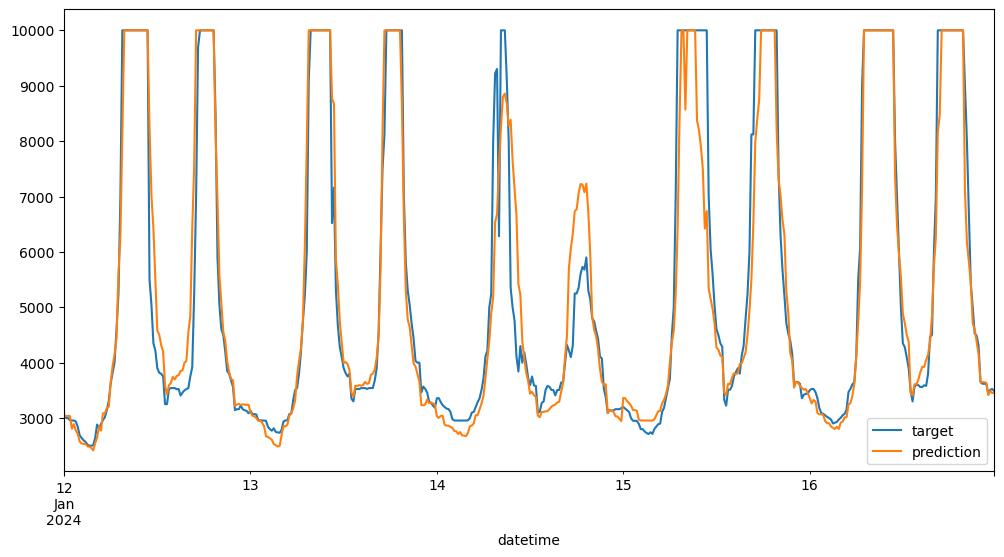

In [28]:
evaluator = ModelEvaluator(model, best_features)
evaluator.evaluate_on_data(X_test, y_test, n, market_type)

### Final Model

In [31]:
# training upto this date
training_upto = datetime.now().date().strftime('%Y-%m-%d')
validation_upto = datetime.now().date().strftime('%Y-%m-%d')
X_train, y_train, X_test, y_test, X_valid, y_valid = build_model._split_data(training_data, training_upto, validation_upto)

In [33]:
model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'regression')
save_pickle(model, MODELS_PATH, f'{market_type}_forecast')

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=65.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=6.522235227616008, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.522235227616008
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


In [34]:
lower_model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'quantile', alpha = 0.1)
save_pickle(lower_model, MODELS_PATH, f'{market_type}_lower')

In [35]:
upper_model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'quantile', alpha = 0.9)
save_pickle(upper_model, MODELS_PATH, f'{market_type}_upper')